In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots, add_identity
from collections import Counter
from matplotlib.lines import Line2D
from tqdm import tqdm

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from matplotlib.gridspec import GridSpec
from collections import defaultdict
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, LeaveOneOut, KFold
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, confusion_matrix
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression

In [3]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [4]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

image_ctx = {'image.cmap': 'cubehelix', 'image.interpolation': 'none'}

In [5]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_males_raw_usage_matrix_v00.parquet').astype(float)
df = df[keep_syllables].groupby(['age','uuid','mouse']).mean()

ages= df.index.get_level_values('age')
weeks = (ages * 7) // 7
df['binned_age'] = weeks
sample = df.groupby(['mouse','binned_age']).first().reset_index()
sample2 = df.groupby(['mouse','binned_age']).last().reset_index()
sample2['binned_age'] = sample2['binned_age']+0.5
df_male = pd.concat([sample,sample2])
df_male.rename(columns={'binned_age': 'age'}, inplace=True)

df_male.set_index(['age', 'mouse'], inplace=True)

In [6]:
# avarage per age or session
m_df= df_male.groupby(['age','mouse']).mean()
# normalize the data
m_norm = mm_norm_col(m_df)

In [7]:
# choose a model for decoder
clf = PLSRegression(n_components=5)
cv = LeaveOneOut()
#number of iterations for shuffle
it=100

In [8]:
format_plots()

In [9]:
#prepare data
data=m_df.copy()
y_age =data.index.get_level_values('age').to_numpy()
X=data.to_numpy()

In [10]:
#decoder
y_pred = cross_val_predict(clf, X, y_age, cv=cv)
r2_age = r2_score(y_age, y_pred)
print(r2_age)

0.8339610061733388


In [11]:
res_age = y_age.flatten()-y_pred.flatten()
res_less = res_age[res_age<0]
res_more = res_age[res_age>0]
print(np.mean(abs(res_less)))
print(np.mean(abs(res_more)))

4.460963991794163
4.528772626305307


In [12]:
df_res = pd.DataFrame(res_age)
df_res['age'] = y_age.flatten()
df_res.to_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/long_residuals_male.parquet')

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/pandas/io/parquet.py:190: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


In [12]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr
print(pearsonr(y_age, y_pred.flatten()))
print(spearmanr(y_age, y_pred.flatten()))

PearsonRResult(statistic=0.9132221619016793, pvalue=0.0)
SignificanceResult(statistic=0.9201026603901056, pvalue=0.0)


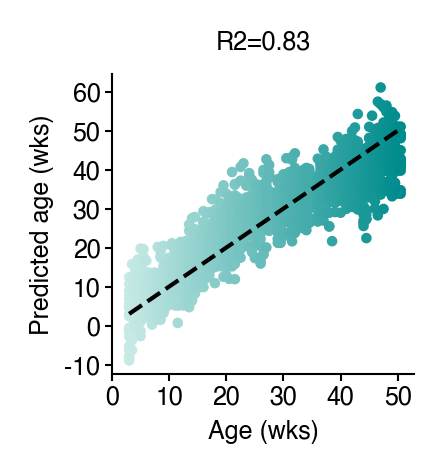

In [13]:
fig = figure(1.3, 1.3)
ax = fig.gca()
plt.scatter(y_age, y_pred, c=y_age, cmap=cmm, s=3)
#add_identity(ax, ls='--', color='k', zorder=-1)
ax.set(xlim=(0, None),yticks=[-10,0, 10, 20, 30, 40,50,60], xticks=[0, 10, 20, 30, 40,50], xlabel="Age (wks)", ylabel="Predicted age (wks)", 
       title=f"R2={r2_age:0.2f}",
      )
plt.plot(y_age, y_age, linestyle='--', color='black')
sns.despine()

In [14]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'age_regression_longv2_male.pdf', bbox_inches='tight')

In [15]:
#shuffle
ysh_score_age=[]
ysh_age=[]
ysh_predict_age=[]
ysh_mse_age=[]
for i in tqdm(range(it)):
    ysh_temp=np.random.permutation(y_age)
    y_pred_temp = cross_val_predict(clf, X, ysh_temp, cv=cv, n_jobs=-1)
    ysh_score_age.append(r2_score(y_age, y_pred_temp))
    ysh_age.extend(ysh_temp)
    ysh_predict_age.extend(y_pred_temp)
    #ysh_mse_age.append(mean_squared_error(y_age, y_pred_temp))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:42:06<00:00, 61.26s/it]


/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


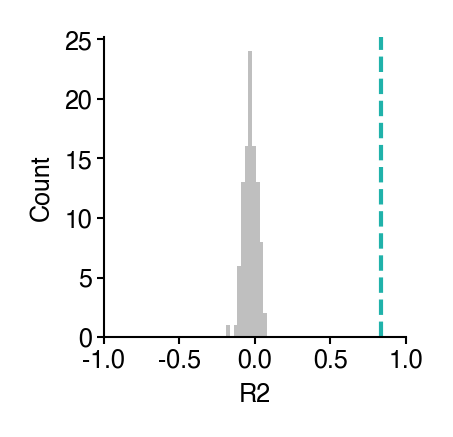

In [16]:
fig = plt.figure(figsize=(1.3, 1.3))
fig.dpi = 300
ax = sns.histplot(data=ysh_score_age, fill=True, element='step', lw=0, color='black', alpha=0.25)
ax.axvline(r2_age, color='#20B2AA', lw=1, linestyle='--')

ax.set(ylabel='Count')
ax.set(xlabel='R2')
plt.xlim([-1,1])
sns.despine()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'age_regression_shuf_longv2_male.pdf', bbox_inches='tight')

In [17]:
## leave one age out

In [18]:
# Prepare data
data = m_df.copy()

# Extract features and target
X = data.to_numpy()
y = data.index.get_level_values('age').to_numpy()
groups = data.index.get_level_values('age').to_numpy()

cv = LeaveOneGroupOut()
cv.get_n_splits(X, y, groups)

# decoder
y_age=y
y_pred = cross_val_predict(clf, X, y_age, groups=groups, cv=cv, n_jobs=-1)
r2_age = r2_score(y_age, y_pred)

In [19]:
r2_age = r2_score(y_age, y_pred)
print(r2_age)

0.8284965309899321


In [20]:
from scipy.stats import pearsonr
print(pearsonr(y_age, np.array(y_pred).flatten()))

PearsonRResult(statistic=0.9102272365647261, pvalue=0.0)


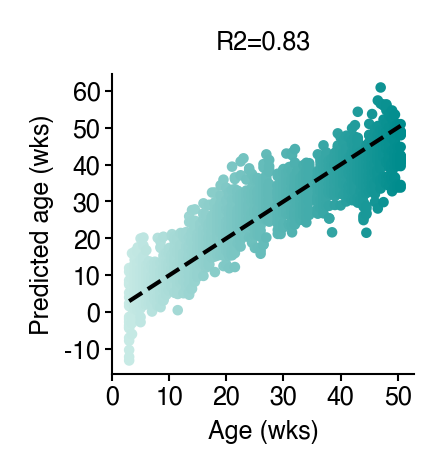

In [21]:
fig = figure(1.3, 1.3)
ax = fig.gca()
plt.scatter(y_age, y_pred, c=y_age, cmap=cmm, s=3)
#add_identity(ax, ls='--', color='k', zorder=-1)
ax.set(xlim=(0, None),yticks=[-10,0, 10, 20, 30, 40,50,60], xticks=[0, 10, 20, 30, 40,50], xlabel="Age (wks)", ylabel="Predicted age (wks)", 
       title=f"R2={r2_age:0.2f}",
      )
plt.plot(y_age, y_age, linestyle='--', color='black')
sns.despine()

In [22]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'age_regression_leave_age_out_longv2_male.pdf', bbox_inches='tight')

In [23]:
## shuffle
#shuffle
ysh_score_age=[]
ysh_age=[]
ysh_predict_age=[]
ysh_mse_age=[]
for i in tqdm(range(it)):
    ysh_temp=np.random.permutation(y_age)
    y_pred_temp = cross_val_predict(clf, X, ysh_temp, groups=groups, cv=cv, n_jobs=-1)
    ysh_score_age.append(r2_score(y_age, y_pred_temp))
    ysh_age.extend(ysh_temp)
    ysh_predict_age.extend(y_pred_temp)
    ysh_mse_age.append(mean_squared_error(y_age, y_pred_temp))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:35<00:00,  3.96s/it]


/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


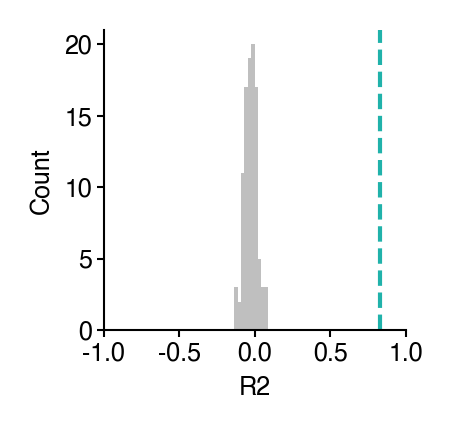

In [24]:
fig = plt.figure(figsize=(1.3, 1.3))
fig.dpi = 300
ax = sns.histplot(data=ysh_score_age, fill=True, element='step', lw=0, color='black', alpha=0.25)
ax.axvline(r2_age, color='#20B2AA', lw=1, linestyle='--')

ax.set(ylabel='Count')
ax.set(xlabel='R2')
plt.xlim([-1,1])
sns.despine()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'age_regression_shuf_longv2_male_age_out.pdf', bbox_inches='tight')